# Regression with TensorFlow Probability (layers)

Source: https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb

In [370]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go

%matplotlib inline
init_notebook_mode(connected=True)

tfd = tfp.distributions

Generate data ($y = F(x)$ linear plus Gaussian noise multiplied by the absolute value of $x$ to spread the points).

In [323]:
n_points = 500

m_true = 4.7
q_true = 1.3

x = tf.expand_dims(tf.linspace(-3., 12., 500), axis=1)

y = m_true * x + q_true + tf.math.abs(x) * tf.random.normal(shape=x.shape, stddev=5.)

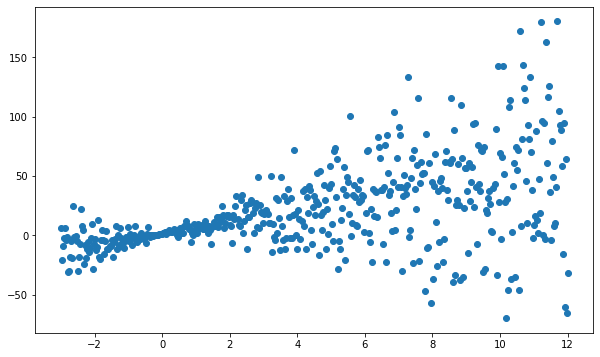

In [324]:
plt.figure(figsize=(10, 6))

plt.scatter(
    x,
    y
)

In [325]:
standard_scaler = StandardScaler()

x_scaled = tf.constant(standard_scaler.fit_transform(x))

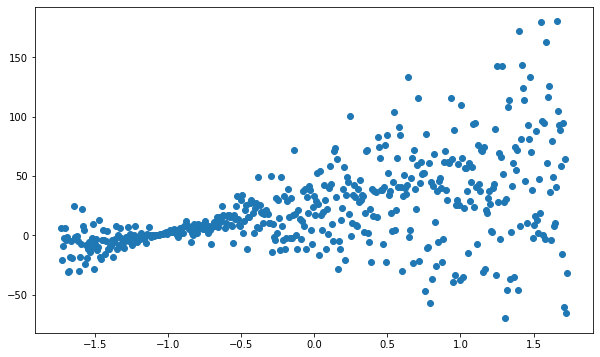

In [326]:
plt.figure(figsize=(10, 6))

plt.scatter(
    x_scaled,
    y
)

## Standard linear regression

Define the negative log likelihood to minimise, assuming a point value and a TensorFlow Probability distributions as the input.

In [256]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

Define model. Output layer is the Normal distribution with which we assume $y$ is distributed around $F(x)$, i.e. we assume

$$
x \sim \mathcal{N}\left( m\,x + q, \sigma \right),
$$

where $m$ and $q$ are parameters to be learned by the model and $\sigma$ can be set to $1$ as standard linear regression does not require it explicitly (maximum likelihood equation does not contain it, nevertheless it can be learned as well as a constant value).

Weights learned by the model
----------------------------
m = 4.323897361755371 (vs m_true = 4.7)
q = 2.5273377895355225 (vs m_true = 1.3)


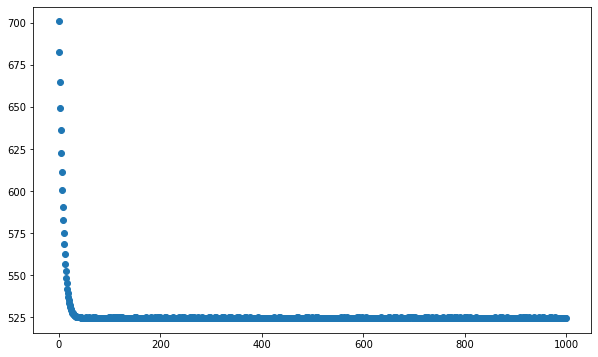

In [346]:
model_naive = tf.keras.Sequential([
    tf.keras.layers.Dense(1),
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[..., :1], scale=1.))
])

model_naive.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)

history = model_naive.fit(x, y, epochs=1000, verbose=False)

plt.figure(figsize=(10, 6))

plt.scatter(
    x=range(len(history.history["loss"])),
    y=history.history["loss"]
)

print("Weights learned by the model")
print("----------------------------")
print(f"m = {model_naive.weights[0].numpy()[0][0]} (vs m_true = {m_true})")
print(f"q = {model_naive.weights[1].numpy()[0]} (vs m_true = {q_true})")

If we pass an input to the model (directly, not to the `predict()` method!), because the last layer generates a TFP distribution, we are returned the (Gaussian) distribution itself (centered in a point depending on the input). Then we can compute the mean etc. like with any distribution.

In [347]:
model_naive(
    tf.expand_dims([0.], axis=1)
).mean()

<tf.Tensor: id=1824866, shape=(1, 1), dtype=float32, numpy=array([[2.5273378]], dtype=float32)>

In [348]:
# We could predict on a batch of values more efficiently,
# producing a batch of distributions and then taking the
# mean of each, but the Jupyter kernel dies.
# pred = [
#     model_naive(
#         tf.expand_dims([data[i, 0]], axis=1)
#     ).mean()[0][0]
#     for i in range(data.shape[0])
# ]

pred = model_naive(
    tf.expand_dims(tf.linspace(-3., 13., 50), axis=1)
).mean()

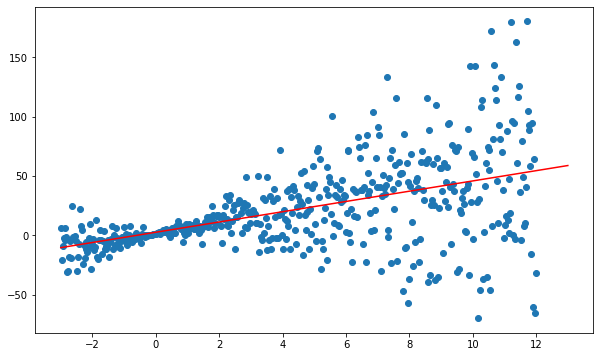

In [349]:
plt.figure(figsize=(10, 6))

plt.scatter(
    x,
    y
)

plt.plot(
    tf.linspace(-3., 13., 50),
    pred,
    color="red"
)

## Fitting $\sigma$ as well

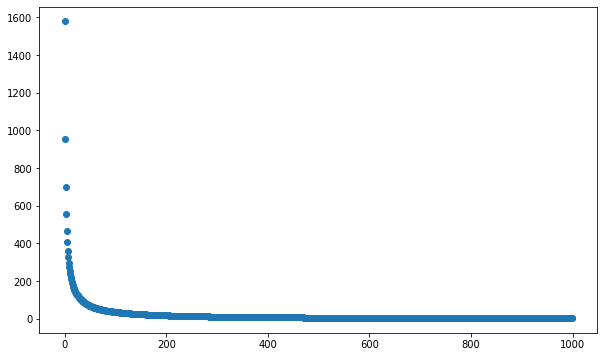

In [476]:
model_sigma = tf.keras.Sequential([
    tf.keras.layers.Dense(1 + 1),
    tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(loc=t[..., :1], scale=0.001 + tf.math.softplus(1.5 * t[..., 1:]))
    )
])

model_sigma.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)

history = model_sigma.fit(x_scaled, y, epochs=1000, verbose=0)

plt.figure(figsize=(10, 6))

plt.scatter(
    x=range(len(history.history["loss"])),
    y=history.history["loss"]
)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



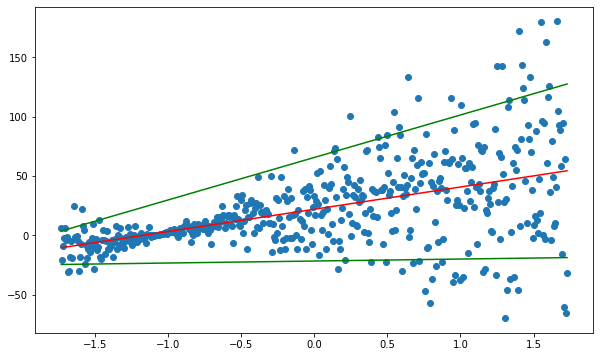

In [477]:
x_test = tf.expand_dims(tf.linspace(tf.reduce_min(x_scaled), tf.reduce_max(x_scaled), 50), axis=1)

pred = model_sigma(x_test).mean()

stddevs = model_sigma(x_test).stddev()

# pred = [
#     model_sigma(
#         tf.expand_dims([p], axis=1)
#     ).mean().numpy()
#     for p in tf.linspace(-20., 60., 50)
# ]
# stddevs = [
#     model_sigma(
#         tf.expand_dims([p], axis=1)
#     ).stddev().numpy()
#     for p in tf.linspace(-20., 60., 50)
# ]

plt.figure(figsize=(10, 6))

plt.scatter(
    x_scaled,
    y
)

plt.plot(
    x_test,
    pred,
    color="red"
)

plt.plot(
    x_test,
    np.array(pred) + np.array([2. * stddev for stddev in stddevs]),
    color="green"
)

plt.plot(
    x_test,
    np.array(pred) + np.array([-2. * stddev for stddev in stddevs]),
    color="green"
)

In [478]:
trace_data = go.Scatter(
    x=tf.reshape(x_scaled, [-1]),
    y=tf.reshape(y, [-1]),
    mode="markers",
    name="Data"
)

trace_fit_mean = go.Scatter(
    x=tf.reshape(x_test, [-1]),
    y=tf.reshape(pred, [-1]),
    name="Mean of fit"
)

trace_fit_2_sigma_upper = go.Scatter(
    x=tf.reshape(x_test, [-1]),
    y=tf.reshape(pred + 2. * stddevs, [-1]),
    marker=dict(color='#2ca02c'),
    name=r"$\pm 2 \text{ st. dev.}$"
)

trace_fit_2_sigma_lower = go.Scatter(
    x=tf.reshape(x_test, [-1]),
    y=tf.reshape(pred - 2. * stddevs, [-1]),
    marker=dict(color='#2ca02c'),
    showlegend=False
)

data = [trace_data, trace_fit_mean, trace_fit_2_sigma_upper, trace_fit_2_sigma_lower]

fig = go.Figure(data=data)

iplot(fig)

In [211]:
model_test = model_sigma = tf.keras.Sequential([
    tf.keras.layers.Dense(1 + 1)
])

model_test.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)

In [213]:
test_tens = model_test(np.array([[4.], [7.], [3.], [1.]]).reshape(-1, 1))

test_tens

<tf.Tensor: id=730195, shape=(1, 1), dtype=float32, numpy=array([[3.8601727]], dtype=float32)>

In [189]:
test_tens[:, 0]

<tf.Tensor: id=550257, shape=(4,), dtype=float32, numpy=array([3.3699746 , 5.8974557 , 2.527481  , 0.84249365], dtype=float32)>

In [190]:
test_tens[..., 0], test_tens[..., :1]

(<tf.Tensor: id=550261, shape=(4,), dtype=float32, numpy=array([3.3699746 , 5.8974557 , 2.527481  , 0.84249365], dtype=float32)>,
 <tf.Tensor: id=550265, shape=(4, 1), dtype=float32, numpy=
 array([[3.3699746 ],
        [5.8974557 ],
        [2.527481  ],
        [0.84249365]], dtype=float32)>)

In [184]:
test_tens[..., 1].numpy(), test_tens[..., 1:].numpy()

(array([2.0516548, 3.590396 , 1.5387411, 0.5129137], dtype=float32),
 array([[2.0516548],
        [3.590396 ],
        [1.5387411],
        [0.5129137]], dtype=float32))

In [ ]:
test_tens

Multiplication of input variables:
- Input $x$ has dimension (1, 1) (a batch of inputs has dimension (batch_size, 1)
- Output of first layer for a single input is a (1, 2) tensor (output for a batch of inputs has dimension (batch_size, 2))

Beacause weight matrices act of variables by multiplication from the right, the weight matrix $M$ of the first layer has dimenison (1, 2) (it's like multiplying a matrix by a scalar). In addition to this, there are two component of the bias vector $b$ (one for each component), which is actually another (1, 2) matrix. The output of the first layer therefore is

$$
y = x M + b\,.
$$

If

$$
x\in\text{Mat}_{\mathbb{R}}(1, 1) \quad M = \left[ M_{11}, M_{12} \right]\in\text{Mat}_{\mathbb{R}}(1, 2),\quad b = \left[b_1, b_2\right]\in\text{Mat}_{\mathbb{R}}(1, 2),
$$

then

$$
y = \left[ x M_{11} + b_1, x M_{12} + b_2 \right]\in\text{Mat}_{\mathbb{R}}(1, 2).
$$

Finally, for a batch of inputs

$$
x_{\text{batch}} = \left( \begin{array}{c}
x_1 \\
x_2 \\
\vdots \\
x_{\texttt{batch_size}}
\end{array}\right) \in\text{Mat}_{\mathbb{R}}(1, \texttt{batch_size})
$$

we get the output

$$
y_{\text{batch}} = \left[ \begin{array}{cc}
x_1 M_{11} + b_1 & x_1 M_{12} + b_2 \\
x_2 M_{11} + b_1 & x_2 M_{12} + b_2 \\
\vdots & \vdots\\
x_{\texttt{batch_size}} M_{11} + b_1 & x_{\texttt{batch_size}} M_{12} + b_2
\end{array} \right]\in\text{Mat}_{\mathbb{R}}(\texttt{batch_size}, 2)
$$

In [83]:
tfd.Normal(loc=test_tens[0, 0], scale=tf.math.softplus(test_tens[0, 1])).sample()

<tf.Tensor: id=2067, shape=(), dtype=float32, numpy=-1.26219>

In [331]:
model_sigma.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             multiple                  4         
_________________________________________________________________
distribution_lambda_36 (Dist multiple                  0         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [109]:
model_sigma.weights

[<tf.Variable 'sequential_3/dense_3/kernel:0' shape=(1, 2) dtype=float32, numpy=array([[ 0.13716736, 11.498482  ]], dtype=float32)>,
 <tf.Variable 'sequential_3/dense_3/bias:0' shape=(2,) dtype=float32, numpy=array([22.180288, 92.99058 ], dtype=float32)>]

In [110]:
model_sigma(
    tf.expand_dims([0.], axis=0)
).mean()

<tf.Tensor: id=68699, shape=(1,), dtype=float32, numpy=array([22.180288], dtype=float32)>

In [111]:
model_sigma(
    tf.expand_dims([0.], axis=1)
).stddev()

<tf.Tensor: id=68743, shape=(1,), dtype=float32, numpy=array([4.6690497], dtype=float32)>

In [112]:
# We could predict on a batch of values more efficiently,
# producing a batch of distributions and then taking the
# mean of each, but the Jupyter kernel dies.

print("Predicting values", end="")

# pred = [
#     model_sigma(
#         tf.expand_dims([data[i, 0]], axis=1)
#     ).mean()[0].numpy()
#     for i in range(data.shape[0])
# ]

pred = model_sigma(
    tf.expand_dims(tf.linspace(-3., 12., 50), axis=1)
).mean()

print(" --> Done")

print("Predicting standard deviations", end="")

# stddevs = [
#     model_sigma(
#         tf.expand_dims([data[i, 0]], axis=1)
#     ).stddev()[0].numpy()
#     for i in range(data.shape[0])
# ]

stddevs = model_sigma(
    tf.expand_dims(tf.linspace(-3., 12., 50), axis=1)
).stddev()

print(" --> Done")

Predicting values --> Done
Predicting standard deviations --> Done


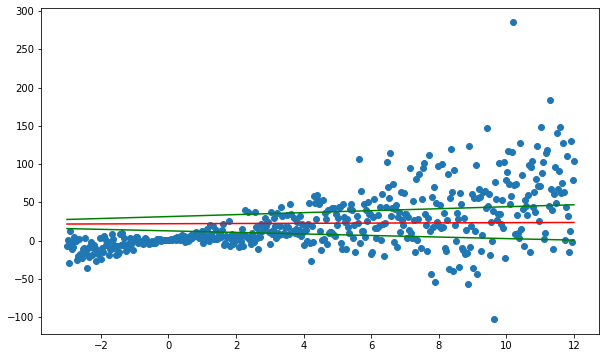

In [113]:
plt.figure(figsize=(10, 6))

plt.scatter(
    data[..., 0],
    data[..., 1]
)

plt.plot(
    tf.linspace(-3., 12., 50).numpy(),
    pred,
    color="red"
)

plt.plot(
    
    tf.linspace(-3., 12., 50).numpy(),
    pred.numpy() + np.array([2. * stddev for stddev in stddevs]),
    color="green"
)

plt.plot(
    tf.linspace(-3., 12., 50).numpy(),
    pred.numpy() + np.array([-2. * stddev for stddev in stddevs]),
    color="green"
)

In [114]:
w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=150, n_tst=150):
  np.random.seed(43)
  def s(x):
    g = (x - x_range[0]) / (x_range[1] - x_range[0])
    return 3 * (0.25 + g**2.)
  x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
  eps = np.random.randn(n) * s(x)
  y = (w0 * x * (1. + np.sin(x)) + b0) + eps
  x = x[..., np.newaxis]
  x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
  x_tst = x_tst[..., np.newaxis]
  return y, x, x_tst

y, x, x_tst = load_dataset()

Weights learned by the model
----------------------------
m = 0.12730957567691803 (vs m_true = 4.7)
q = 5.198181629180908 (vs m_true = 1.3)


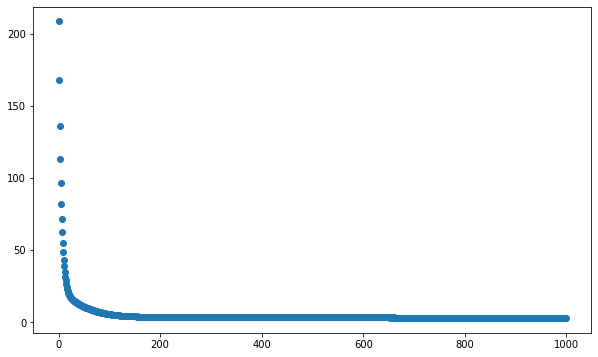

In [115]:
model_sigma = tf.keras.Sequential([
    tf.keras.layers.Dense(1 + 1),
    tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(loc=t[..., 0], scale=0.01 + tf.math.softplus(0.05 * t[..., 1]))
    )
])

model_sigma.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)

#history = model_sigma.fit(x, y, epochs=1000, verbose=0)
history = model_sigma.fit(tf.expand_dims(x, axis=1).numpy(), y, epochs=1000, verbose=0)

plt.figure(figsize=(10, 6))

plt.scatter(
    x=range(len(history.history["loss"])),
    y=history.history["loss"]
)

print("Weights learned by the model")
print("----------------------------")
print(f"m = {model_sigma.weights[0].numpy()[0][0]} (vs m_true = {m_true})")
print(f"q = {model_sigma.weights[1].numpy()[0]} (vs m_true = {q_true})")

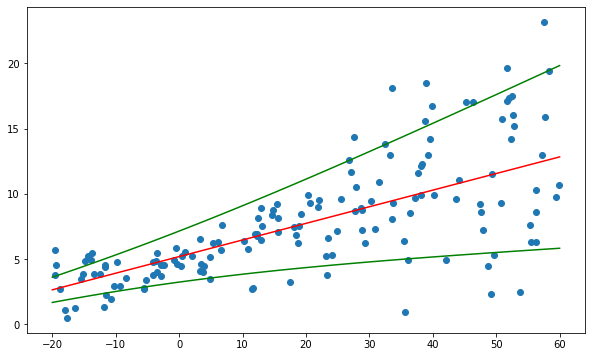

In [116]:
pred = model_sigma(
    tf.expand_dims(tf.linspace(-20., 60., 50), axis=1)
).mean()

stddevs = model_sigma(
    tf.expand_dims(tf.linspace(-20., 60., 50), axis=1)
).stddev()

plt.figure(figsize=(10, 6))

plt.scatter(
    x, y
)

plt.plot(
    tf.linspace(-20., 60., 50).numpy(),
    pred,
    color="red"
)

plt.plot(
    tf.linspace(-20., 60., 50).numpy(),
    pred.numpy() + np.array([2. * stddev for stddev in stddevs]),
    color="green"
)

plt.plot(
    tf.linspace(-20., 60., 50).numpy(),
    pred.numpy() + np.array([-2. * stddev for stddev in stddevs]),
    color="green"
)